In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
DATA_DIR = '../../../Workplace/Ultrasound/Dataset/benign/'

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        #plt.imshow(image, cmap='magma') #히트맵 용
    plt.show()

In [5]:
# helper function for data visualization
def visualize_save(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()
    cv2.imwrite('./results/%s.png'%i, image)

### DataLoader

* Writing helper class for data extraction, transformation and preprocessing

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['benign']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(512, 512), interpolation=cv2.INTER_AREA)


        mask = cv2.imread(self.masks_fps[i], 0)
        #mask = cv2.flip(mask, 1)
        #mask = cv2.flip(mask, 0)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = cv2.resize(mask, dsize=(512, 512), interpolation=cv2.INTER_AREA)
        mask = mask.reshape(512, 512, 1)
        #mask = np.stack(masks, axis=-1).astype('float')
        
        
        # mask reverse
        #print(mask.shape)
        #mask = cv2.bitwise_not(mask)
        #mask = mask.reshape(512, 512, 1)
        #print(mask.shape, mask.dtype)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

 
        return image, mask
        
    def __len__(self):
        return len(self.ids)

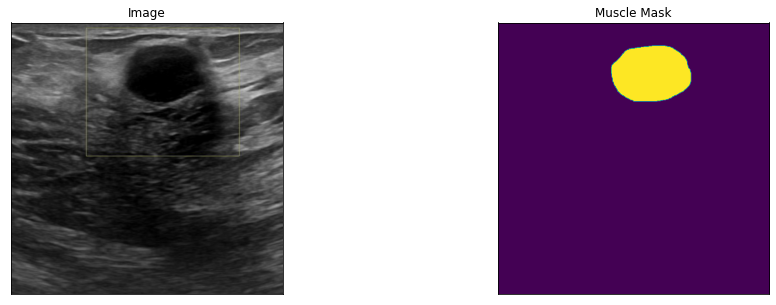

In [8]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['benign'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    muscle_mask=mask.squeeze(),
)

In [9]:
import albumentations as albu

In [10]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        #albu.IAAAdditiveGaussianNoise(p=0.2),
        #albu.IAAPerspective(p=0.5),
        
        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                #albu.RandomBrightness(p=1),
                #albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                #albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                #albu.RandomContrast(p=1),
                #albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
        
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

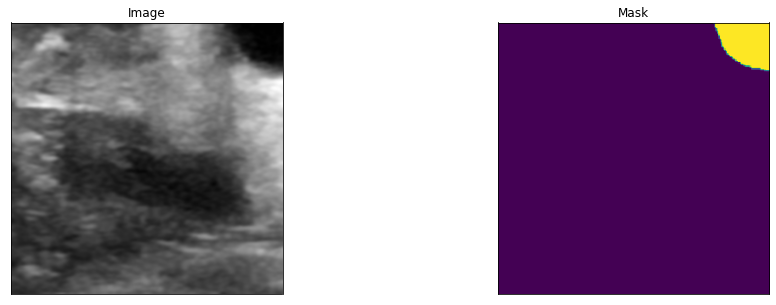

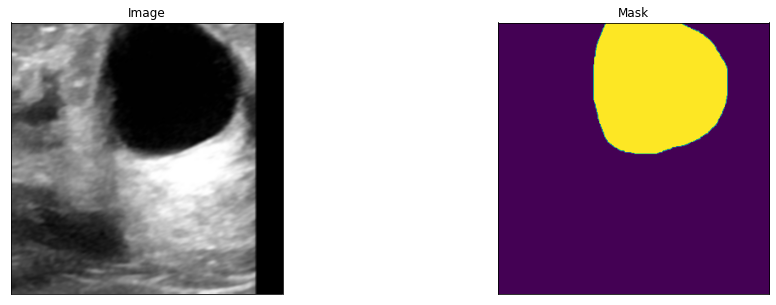

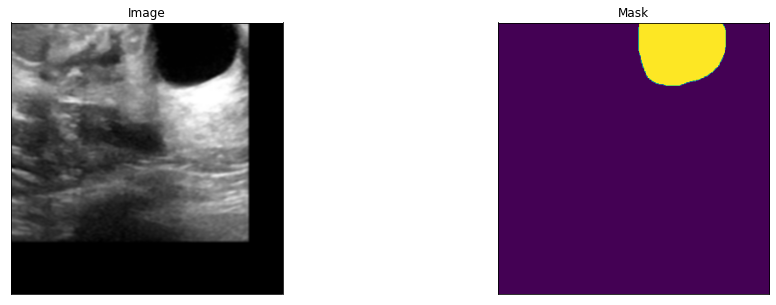

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['benign'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    #visualize(image=image, mask=mask.squeeze(-1))
    visualize(image=image, mask=mask.squeeze())

### Create model and train

In [12]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [13]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['benign']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to C:\Users\jhlee/.cache\torch\hub\checkpoints\efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

In [15]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [16]:
import segmentation_models_pytorch.utils

In [18]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss()
#loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [19]:
# create epoch runners 

# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


In [20]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 SUPER'

In [21]:
# train model for 40 epochs

max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './weights/best_model_Unet_timmEfficient7_dicebcd.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 80/80 [00:05<00:00, 14.78it/s, dice_loss + bce_loss - -88.77, iou_score - 7.753]
Model saved!

Epoch: 1
valid: 100%|██████████| 80/80 [00:05<00:00, 15.27it/s, dice_loss + bce_loss - -333.8, iou_score - 21.06]
Model saved!

Epoch: 2
valid: 100%|██████████| 80/80 [00:05<00:00, 15.61it/s, dice_loss + bce_loss - -160.2, iou_score - 26.97]
Model saved!

Epoch: 3
valid: 100%|██████████| 80/80 [00:05<00:00, 15.71it/s, dice_loss + bce_loss - -180.1, iou_score - 31.28]
Model saved!

Epoch: 4
valid: 100%|██████████| 80/80 [00:05<00:00, 15.00it/s, dice_loss + bce_loss - -772.5, iou_score - 26.93]

Epoch: 5
valid: 100%|██████████| 80/80 [00:05<00:00, 14.69it/s, dice_loss + bce_loss - -1.185e+03, iou_score - 23.86]

Epoch: 6
valid: 100%|██████████| 80/80 [00:05<00:00, 15.16it/s, dice_loss + bce_loss - -835.9, iou_score - 23.67]

Epoch: 7
valid: 100%|██████████| 80/80 [00:04<00:00, 16.29it/s, dice_loss + bce_loss - -400.2, iou_score - 21.47]

Epoch: 8
valid: 100%|██

### Test best saved model

In [22]:
# load best saved checkpoint
best_model = torch.load('./weights/best_model_Unet_timmEfficient7_dicebcd.pth')

In [23]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, shuffle=False)

In [24]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 57/57 [00:03<00:00, 15.25it/s, dice_loss + bce_loss - -2.489e+03, iou_score - 36.4] 


In [25]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

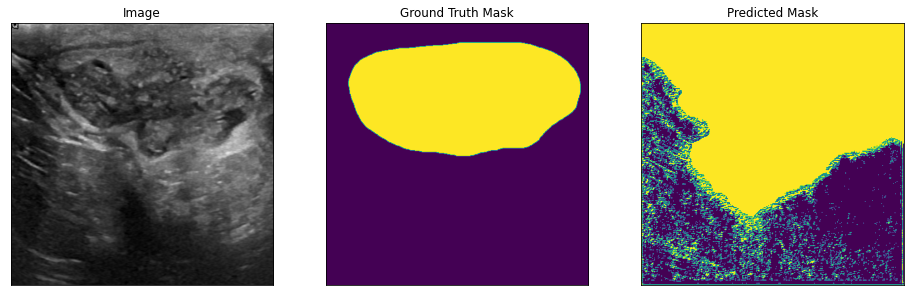

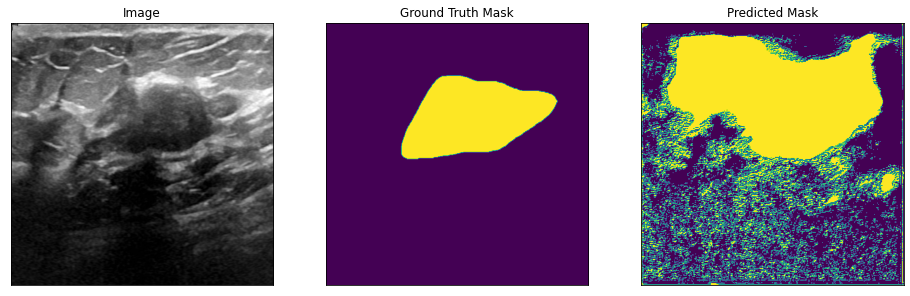

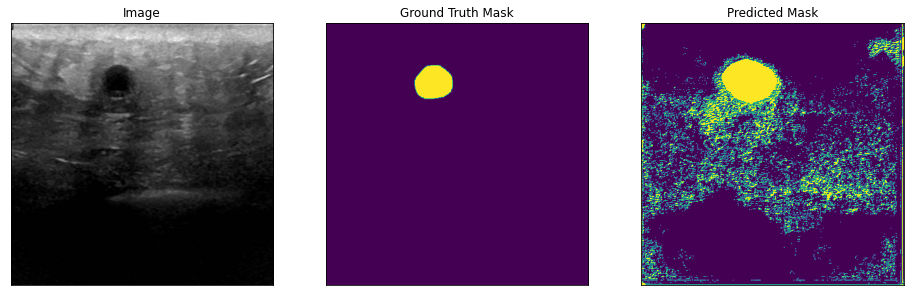

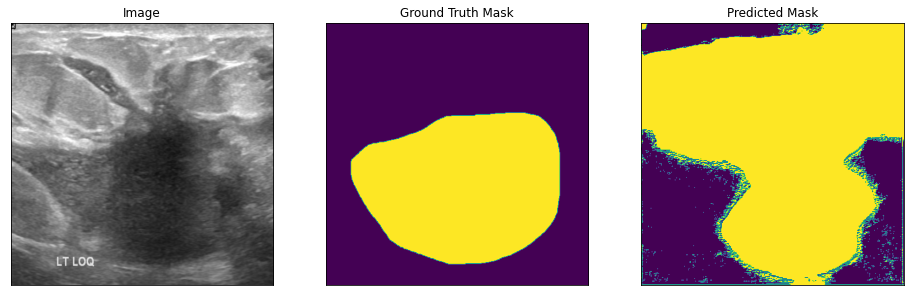

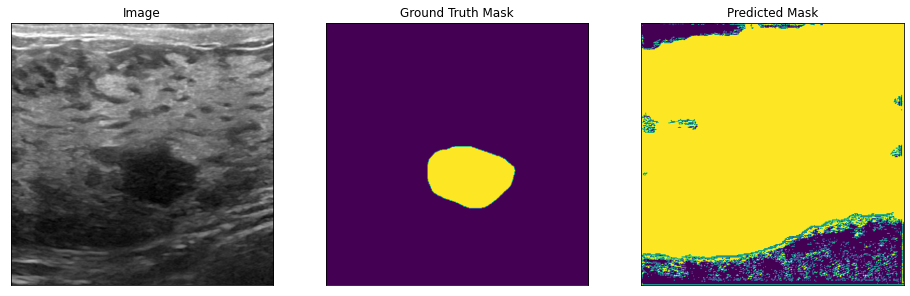

In [26]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )